<a href="https://colab.research.google.com/github/ShraddhaSharma24/Machine-learning/blob/main/Anomaly_Detection_in_Smart_meter_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!kaggle datasets download -d uciml/electric-power-consumption-data-set --unzip

Dataset URL: https://www.kaggle.com/datasets/uciml/electric-power-consumption-data-set
License(s): DbCL-1.0
 67% 13.0M/19.4M [00:00<00:00, 115MB/s]
100% 19.4M/19.4M [00:00<00:00, 143MB/s]


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Dense

In [3]:
# Load dataset
df = pd.read_csv('household_power_consumption.txt', sep=';', low_memory=False, na_values=['?'])

# Convert Date and Time into a single datetime column
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %H:%M:%S')
df = df.drop(columns=['Date', 'Time'])

# Convert numeric columns
df = df.apply(pd.to_numeric, errors='coerce')

# Fill missing values with the median
df.fillna(df.median(), inplace=True)

# Select relevant features
features = ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity']
df = df[['Datetime'] + features]

In [4]:
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df[features]), columns=features)
df_scaled['Datetime'] = df['Datetime']

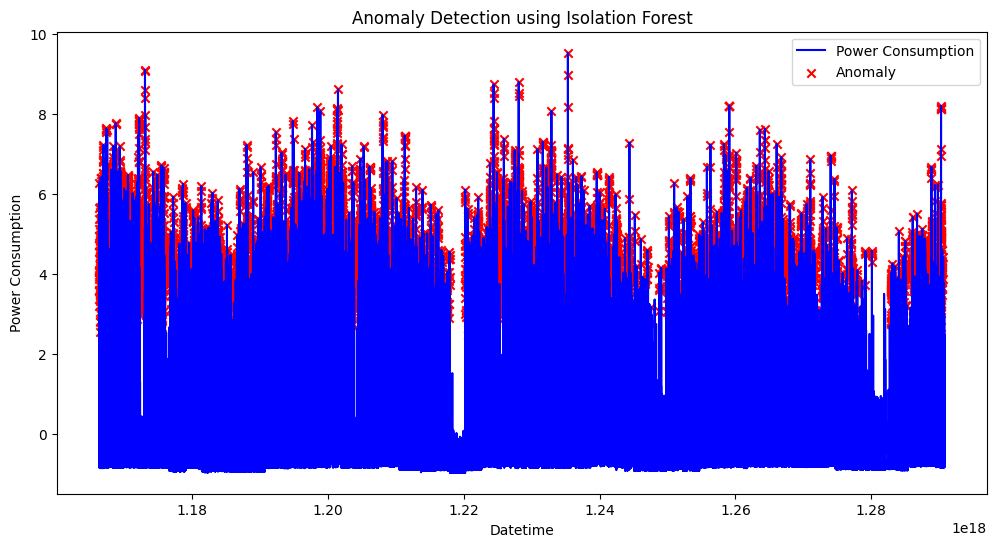

In [5]:
# Train Isolation Forest
model_if = IsolationForest(n_estimators=100, contamination=0.01, random_state=42)
df_scaled['Anomaly_IF'] = model_if.fit_predict(df_scaled[features])

# Convert -1 (Anomaly) and 1 (Normal) to 0 and 1
df_scaled['Anomaly_IF'] = df_scaled['Anomaly_IF'].map({1: 0, -1: 1})

# Plot anomalies
plt.figure(figsize=(12,6))
plt.plot(df_scaled['Datetime'], df_scaled['Global_active_power'], label='Power Consumption', color='blue')
plt.scatter(df_scaled['Datetime'][df_scaled['Anomaly_IF'] == 1],
            df_scaled['Global_active_power'][df_scaled['Anomaly_IF'] == 1],
            color='red', label='Anomaly', marker='x')
plt.xlabel('Datetime')
plt.ylabel('Power Consumption')
plt.title('Anomaly Detection using Isolation Forest')
plt.legend()
plt.show()

 Autoencoder for Anomaly Detection

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
7296/7296 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - loss: 0.6538 - val_loss: 0.4166
Epoch 2/20
7296/7296 ━━━━━━━━━━━━━━━━━━━━ 36s 3ms/step - loss: 0.5679 - val_loss: 0.4162
Epoch 3/20
7296/7296 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - loss: 0.5685 - val_loss: 0.4161
Epoch 4/20
7296/7296 ━━━━━━━━━━━━━━━━━━━━ 35s 3ms/step - loss: 0.5683 - val_loss: 0.4161
Epoch 5/20
7296/7296 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 0.5682 - val_loss: 0.4161
Epoch 6/20
7296/7296 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 0.5694 - val_loss: 0.4161
Epoch 7/20
7296/7296 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 0.5691 - val_loss: 0.4160
Epoch 8/20
7296/7296 ━━━━━━━━━━━━━━━━━━━━ 39s 3ms/step - loss: 0.5677 - val_loss: 0.4160
Epoch 9/20
7296/7296 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 0.5693 - val_loss: 0.4160
Epoch 10/20
7296/7296 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 0.5680 - val_loss: 0.4159
Epoch 11/20
7296/7296 ━━━━━━━━━━━━━━━━━━━━ 43s 3ms/step - loss: 0.5664 - val_loss: 0.4159
Epoch 12/20
7296/72

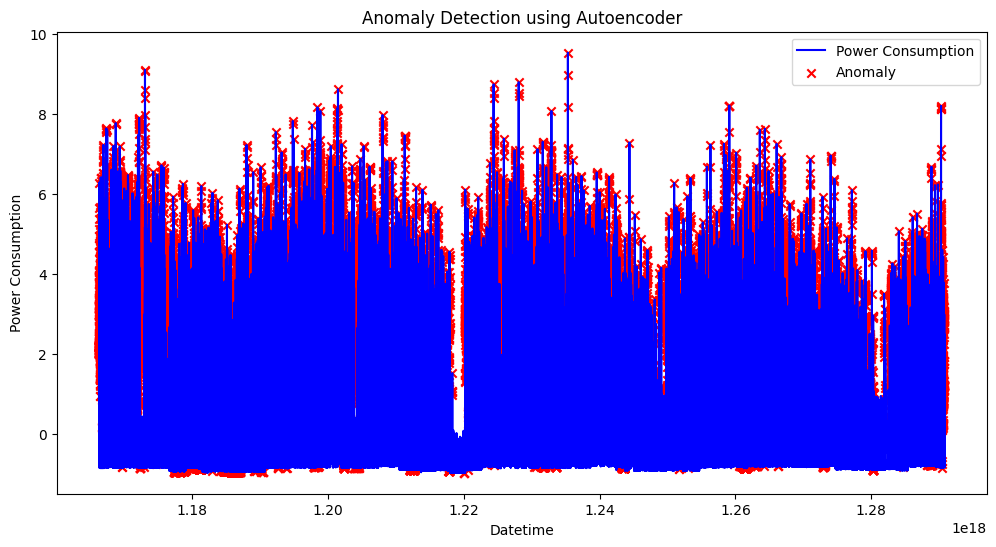

In [6]:
# Build Autoencoder Model
input_dim = len(features)
autoencoder = keras.Sequential([
    Dense(16, activation='relu', input_shape=(input_dim,)),
    Dense(8, activation='relu'),
    Dense(4, activation='relu'),
    Dense(8, activation='relu'),
    Dense(16, activation='relu'),
    Dense(input_dim, activation='sigmoid')
])

autoencoder.compile(optimizer='adam', loss='mse')

# Train Autoencoder
X_train = df_scaled[features].values
autoencoder.fit(X_train, X_train, epochs=20, batch_size=256, shuffle=True, validation_split=0.1)

# Calculate reconstruction errors
reconstructions = autoencoder.predict(X_train)
mse = np.mean(np.power(X_train - reconstructions, 2), axis=1)

# Set threshold and detect anomalies
threshold = np.percentile(mse, 95)
df_scaled['Anomaly_AE'] = (mse > threshold).astype(int)

# Plot Anomalies detected by Autoencoder
plt.figure(figsize=(12,6))
plt.plot(df_scaled['Datetime'], df_scaled['Global_active_power'], label='Power Consumption', color='blue')
plt.scatter(df_scaled['Datetime'][df_scaled['Anomaly_AE'] == 1],
            df_scaled['Global_active_power'][df_scaled['Anomaly_AE'] == 1],
            color='red', label='Anomaly', marker='x')
plt.xlabel('Datetime')
plt.ylabel('Power Consumption')
plt.title('Anomaly Detection using Autoencoder')
plt.legend()
plt.show()


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import DBSCAN
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Dense

In [8]:
# Load dataset
df = pd.read_csv('household_power_consumption.txt', sep=';', low_memory=False, na_values=['?'])

# Convert Date and Time into a single datetime column
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %H:%M:%S')
df = df.drop(columns=['Date', 'Time'])

# Convert numeric columns
df = df.apply(pd.to_numeric, errors='coerce')

# Fill missing values with the median
df.fillna(df.median(), inplace=True)

# Select relevant features
features = ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity']
df = df[['Datetime'] + features]

# Normalize data
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df[features]), columns=features)
df_scaled['Datetime'] = df['Datetime']

Anomaly Detection using Different Methods


1.Isolation Forest

In [9]:
model_if = IsolationForest(n_estimators=100, contamination=0.01, random_state=42)
df_scaled['Anomaly_IF'] = model_if.fit_predict(df_scaled[features])
df_scaled['Anomaly_IF'] = df_scaled['Anomaly_IF'].map({1: 0, -1: 1})

2.One-Class SVM

In [ ]:
model_svm = OneClassSVM(nu=0.01, kernel="rbf", gamma=0.1)
df_scaled['Anomaly_SVM'] = model_svm.fit_predict(df_scaled[features])
df_scaled['Anomaly_SVM'] = df_scaled['Anomaly_SVM'].map({1: 0, -1: 1})

3️. Local Outlier Factor (LOF

In [ ]:
model_lof = LocalOutlierFactor(n_neighbors=20, contamination=0.01)
df_scaled['Anomaly_LOF'] = model_lof.fit_predict(df_scaled[features])
df_scaled['Anomaly_LOF'] = df_scaled['Anomaly_LOF'].map({1: 0, -1: 1})

4.DBSCAN (Density-Based Clustering)

In [ ]:
model_dbscan = DBSCAN(eps=1.5, min_samples=10)
df_scaled['Anomaly_DBSCAN'] = model_dbscan.fit_predict(df_scaled[features])

# Convert DBSCAN labels (-1 for anomalies, 0 or higher for normal clusters)
df_scaled['Anomaly_DBSCAN'] = df_scaled['Anomaly_DBSCAN'].apply(lambda x: 1 if x == -1 else 0)

5.Autoencoder (Deep Learning)

In [ ]:
# Build Autoencoder Model
input_dim = len(features)
autoencoder = keras.Sequential([
    Dense(16, activation='relu', input_shape=(input_dim,)),
    Dense(8, activation='relu'),
    Dense(4, activation='relu'),
    Dense(8, activation='relu'),
    Dense(16, activation='relu'),
    Dense(input_dim, activation='sigmoid')
])

autoencoder.compile(optimizer='adam', loss='mse')

# Train Autoencoder
X_train = df_scaled[features].values
autoencoder.fit(X_train, X_train, epochs=20, batch_size=256, shuffle=True, validation_split=0.1)

# Calculate reconstruction errors
reconstructions = autoencoder.predict(X_train)
mse = np.mean(np.power(X_train - reconstructions, 2), axis=1)

# Set threshold and detect anomalies
threshold = np.percentile(mse, 95)
df_scaled['Anomaly_AE'] = (mse > threshold).astype(int)

Visualizing Anomalies

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(df_scaled['Datetime'], df_scaled['Global_active_power'], label='Power Consumption', color='blue')

# Mark anomalies
methods = ['Anomaly_IF', 'Anomaly_SVM', 'Anomaly_LOF', 'Anomaly_DBSCAN', 'Anomaly_AE']
colors = ['red', 'green', 'purple', 'orange', 'brown']

for method, color in zip(methods, colors):
    plt.scatter(df_scaled['Datetime'][df_scaled[method] == 1],
                df_scaled['Global_active_power'][df_scaled[method] == 1],
                color=color, label=method, marker='x')

plt.xlabel('Datetime')
plt.ylabel('Power Consumption')
plt.title('Anomaly Detection Using Multiple Methods')
plt.legend()
plt.show()